# Prepare data

In [1]:
import tqdm
import time
import numpy as np
import pandas as pd
from math import sqrt
from sklearn import  metrics
 
# custom utils and random forest scripts
from Utils import ETL_emb, count_test_period

# dummy variable list            
from holidayList import hol_list

LOGNUMBER = 'e2e_seq2seq'

print('Starting the ETL process')

start_time = time.time()
df_train,df_sub = ETL_emb()
test_lengths = count_test_period(df_sub)
elapsed_time = time.time() - start_time 

print('Time taken to complete the ETL process {}'.format(elapsed_time))

forecast_ids = list(test_lengths.keys())
site_ids = list(df_sub.SiteId.unique())

# suppress pandas warnings
# do not do this in production!
pd.set_option('mode.chained_assignment', None)

submission_df = pd.read_csv('../data/forecast/submission_format.csv')
submission_df = submission_df.set_index('obs_id')

def preprocess_seq2seq(df_train,df_sub):
    # add train / test marker
    df_train['is_train'] = 1
    df_sub['is_train'] = 0

    # merge dataframes together
    data_df = df_train.append(df_sub)
    del df_train,df_sub
    
    # sort dataframe by site_id and timestamp 
    # so that we could easily use ar features 
    # and do indexing
    data_df['Timestamp'] = pd.to_datetime(data_df['Timestamp'] )
    data_df = data_df.sort_values(by = ['SiteId','Timestamp'])
    
    # replace non-existent temperature with base temperature
    data_df.loc[(data_df.Temperature == -1),'Temperature'] = data_df.loc[(data_df.Temperature == -1),'BaseTemperature']    
    
    
    # produce future features for temperature
    """
    print('Producing shifted future temperature features ...')
    with tqdm.tqdm(total=len(site_ids)) as pbar:
        for site_id in site_ids:
            data_df.loc[data_df.SiteId == site_id, 'FT1'] = data_df.loc[data_df.SiteId == site_id, 'Temperature'].shift(-1)
            data_df.loc[data_df.SiteId == site_id, 'FT5'] = data_df.loc[data_df.SiteId == site_id, 'Temperature'].shift(-5)
            data_df.loc[data_df.SiteId == site_id, 'FT10'] = data_df.loc[data_df.SiteId == site_id, 'Temperature'].shift(-10)
            data_df.loc[data_df.SiteId == site_id, 'FT50'] = data_df.loc[data_df.SiteId == site_id, 'Temperature'].shift(-50)

            data_df.loc[data_df.SiteId == site_id, 'FT1'] = data_df.loc[data_df.SiteId == site_id, 'FT1'].fillna(method='ffill')
            data_df.loc[data_df.SiteId == site_id, 'FT5'] = data_df.loc[data_df.SiteId == site_id, 'FT5'].fillna(method='ffill')
            data_df.loc[data_df.SiteId == site_id, 'FT10'] = data_df.loc[data_df.SiteId == site_id, 'FT10'].fillna(method='ffill')
            data_df.loc[data_df.SiteId == site_id, 'FT50'] = data_df.loc[data_df.SiteId == site_id, 'FT50'].fillna(method='ffill')

            pbar.update(1)
    """
    
    # remove very drastic outliers 
    print('Removing drastic outliers ... ')
    with tqdm.tqdm(total=len([1964, 1968, 1969, 4325, 5276, 5536])) as pbar:
        for forecast_id in [1964, 1968, 1969, 4325, 5276, 5536]:
            data_df.loc[(data_df.ForecastId == forecast_id)
                        &(data_df.Value>10**8), 'Value'] = np.nan

            data_df.loc[data_df.ForecastId == forecast_id, 'Value'] = data_df.loc[data_df.ForecastId == forecast_id, 'Value'].fillna(method='ffill')
            data_df.loc[data_df.ForecastId == forecast_id, 'Value'] = data_df.loc[data_df.ForecastId == forecast_id, 'Value'].fillna(method='bfill')

            pbar.update(1)
            
    return data_df

data_df = preprocess_seq2seq(df_train,df_sub)
# reset index to make sure we do not have double indexes and for easier indexing
data_df = data_df.reset_index()
del data_df['index']

# leave only the first holiday
data_df = data_df[(data_df['obs_id'].shift(+1) != data_df['obs_id'])]
data_df = data_df.reset_index()
del data_df['index']
# fill days wo holidays with -1
data_df['Holiday'] = data_df['Holiday'].fillna(value=-1)

Starting the ETL process
Time taken to complete the ETL process 163.90319728851318


 17%|█▋        | 1/6 [00:00<00:00,  6.71it/s]

Removing drastic outliers ... 


100%|██████████| 6/6 [00:00<00:00,  6.63it/s]


In [2]:
# interpolation pipeline
# (1) find normal series
# (2) find series with all NaNs => mark as submit zeroes
# (3) use linear interpolation for series with < 0.2 NaNs
# (4) series with > 0.5 NaNs => submit averages
# (5) series with at least one test set worth of data immediately before test set => truncate train data
# (6) submit averages for the remaining series
# in the end we have
# (1) normal or interpolated series
# (2) submit zeroes
# (3) submit averages


data_df['is_null'] = 0
data_df.loc[pd.isnull(data_df.Value),'is_null'] = 1

# find normal time series
null_df = data_df[data_df.is_train == 1].groupby(['ForecastId'])['is_null'].sum()
count_df = data_df[data_df.is_train == 1].groupby(['ForecastId'])['is_null'].count()
stat_df = pd.DataFrame()
stat_df['null_count'] = null_df
stat_df['count'] = count_df
stat_df['percent_null'] = stat_df['null_count']/stat_df['count']
# stat_df[stat_df.percent_null>0].percent_null.plot(kind='hist')
normal_forecast_ids = list(stat_df[(stat_df.percent_null==0)].index.values)

# all non-normal series
# that have all the train dataset values equal to NAs
submit_zeroes = list(stat_df[(stat_df.percent_null==1)].index)
# that have the majority of values equal to NAs
submit_averages = list(stat_df[(stat_df.percent_null>0.5)
                               &(stat_df.percent_null<1)].index)
# use linear interpolation for values between 0 and 0.2
linear_interpolation = list(stat_df[(stat_df.percent_null>0)
                               &(stat_df.percent_null<0.2)].index)

data_df.loc[data_df.ForecastId.isin(linear_interpolation),'Value'] = data_df.loc[data_df.ForecastId.isin(linear_interpolation),'Value'].interpolate(method='linear')

try_truncating = list(stat_df[(stat_df.percent_null>0.2)
                               &(stat_df.percent_null<0.5)].index)

use_last_window = []

for forecast_id in try_truncating:
    test_len = data_df[(data_df.ForecastId==forecast_id)
                        &(data_df.is_train==0)].shape[0]
    
    last_window = data_df[(data_df.ForecastId==forecast_id)
                        &(data_df.is_train==1)].iloc[-test_len * 2 - 1:]
    
    non_blank_last_window = last_window[pd.notnull(last_window.Value)].shape[0] / last_window.shape[0]
    
    if (non_blank_last_window == 1):
        use_last_window.append(forecast_id)
    else:
        submit_averages.append(forecast_id)
        
# drop non-last values for these forecast_ids
for forecast_id in use_last_window:
    
    test_len = data_df[(data_df.ForecastId==forecast_id)
                        &(data_df.is_train==0)].shape[0]

    drop_index = data_df[data_df.ForecastId == forecast_id].index[:-test_len * 3 - 1]

    data_df.drop(index=drop_index,inplace=True,axis=0)         
    
train_forecast_ids = normal_forecast_ids + linear_interpolation + use_last_window    

# Try e2e models

In [3]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
from torch.optim.lr_scheduler import ReduceLROnPlateau,MultiStepLR
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

# custom classes
from SDataset import S2SDataset
from ELstm import E2ELSTM,WMSELoss

import torch.utils.data as data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

import pandas as pd
import numpy as np
from math import sqrt

def train(train_loader,
          model,
          criterion,
          optimizer,
          epoch):
    losses = AverageMeter()
    # switch to train mode
    model.train()

    for i, (X_sequences_ar,X_sequences_meta,y_sequences) in enumerate(train_loader):
        
        # transform data from Batch x Window x Etc into Batch x Etc format
        X_sequences_meta = X_sequences_meta.view(-1,X_sequences_meta.size(2),X_sequences_meta.size(3))
        X_sequences_ar = X_sequences_ar.view(-1,X_sequences_ar.size(2),1).float()
        y_sequences = y_sequences.view(-1,y_sequences.size(2)).float()
        X_sequences_temp = X_sequences_meta[:,:,0:1].float()
        X_sequences_meta = X_sequences_meta[:,:,1:].long()

        x_temp_var = torch.autograd.Variable(X_sequences_temp.cuda(async=True))
        x_meta_var = torch.autograd.Variable(X_sequences_meta.cuda(async=True))
        x_ar_var = torch.autograd.Variable(X_sequences_ar.cuda(async=True))
        y_var = torch.autograd.Variable(y_sequences.cuda(async=True))

        # compute output
        output = model(x_temp_var,x_meta_var,x_ar_var)
        loss = criterion(output, y_var)

        # measure accuracy and record loss
        losses.update(loss.data[0], X_sequences_meta.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                   epoch, i, len(train_loader), loss=losses))        
           
    return losses.avg

def validate(val_loader, model, criterion):
    losses = AverageMeter()
    # switch to evaluate mode
    model.eval()

    for i, (X_sequences_ar,X_sequences_meta,y_sequences) in enumerate(val_loader):
        
        # transform data from Batch x Window x Etc into Batch x Etc format
        X_sequences_meta = X_sequences_meta.view(-1,X_sequences_meta.size(2),X_sequences_meta.size(3))
        X_sequences_ar = X_sequences_ar.view(-1,X_sequences_ar.size(2),1).float()
        y_sequences = y_sequences.view(-1,y_sequences.size(2)).float()
        X_sequences_temp = X_sequences_meta[:,:,0:1].float()
        X_sequences_meta = X_sequences_meta[:,:,1:].long()

        x_temp_var = torch.autograd.Variable(X_sequences_temp.cuda(async=True))
        x_meta_var = torch.autograd.Variable(X_sequences_meta.cuda(async=True))
        x_ar_var = torch.autograd.Variable(X_sequences_ar.cuda(async=True))
        y_var = torch.autograd.Variable(y_sequences.cuda(async=True))

        # compute output
        output = model(x_temp_var,x_meta_var,x_ar_var)
        loss = criterion(output, y_var)
        
        # measure accuracy and record loss
        losses.update(loss.data[0], X_sequences_meta.size(0))
        
        if i % 10 == 0:
            print('Test: [{0}/{1}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                   i, len(val_loader), loss=losses))      
            
    return losses.avg

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [4]:
# key params
lr = 1e-3
start_epoch = 0
epochs = 40
# 16 samples per batch
batch_size = 20
# lstm params
in_sequence_len = 192
out_sequence_len = 192
features_meta_total = 72
features_ar_total = 1
meta_hidden_layer_length = 192
ar_hidden_layer_length = 192
meta_hidden_layers = 2
ar_hidden_layers = 2
lstm_dropout = 0
# MLP model end params
# B x meta_hidden_layer_length || B x ar_hidden_layer_length => classifier_hidden_length => out_sequence_len
classifier_hidden_length = 512

In [ ]:
# PyTorch training loop sugar

temp_features = ['Temperature']
hol_emb_features = ['Holiday']
time_emb_features = ['year', 'month', 'day', 'hour', 'minute','dow']
target = ['Value']
predictors = temp_features + hol_emb_features + time_emb_features

model = E2ELSTM(in_sequence_len = in_sequence_len,
                 out_sequence_len = out_sequence_len,
                 features_meta_total = features_meta_total,
                 features_ar_total = features_ar_total,
                 meta_hidden_layer_length = meta_hidden_layer_length,
                 ar_hidden_layer_length = ar_hidden_layer_length,
                 meta_hidden_layers = meta_hidden_layers,
                 ar_hidden_layers = ar_hidden_layers,
                 lstm_dropout =lstm_dropout,
                 classifier_hidden_length = classifier_hidden_length)

model.cuda()

train_dataset = S2SDataset(df = data_df[(~data_df.ForecastId.isin(list(set(data_df.ForecastId.unique()) - set(train_forecast_ids))))],
                     series_type = '15_mins',
                     in_sequence_len = 192,
                     out_sequence_len = 192,
                     target = 'Value',
                     mode = 'train',
                     split_mode = 'random',
                     predictors = predictors)

val_dataset = S2SDataset(df = data_df[(~data_df.ForecastId.isin(list(set(data_df.ForecastId.unique()) - set(train_forecast_ids))))],
                     series_type = '15_mins',
                     in_sequence_len = 192,
                     out_sequence_len = 192,
                     target = 'Value',
                     mode = 'val',
                     split_mode = 'random',
                     predictors = predictors)  

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,        
    shuffle=True,
    num_workers=1,
    pin_memory=True,
    drop_last=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,        
    shuffle=True,
    num_workers=1,
    pin_memory=True,
    drop_last=True)

criterion = nn.MSELoss().cuda()

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                             lr = lr)

scheduler = ReduceLROnPlateau(optimizer = optimizer,
                                          mode = 'min',
                                          factor = 0.1,
                                          patience = 4,
                                          verbose = True,
                                          threshold = 1e-3,
                                          min_lr = 1e-7
                                          )

Creating dataset object ...
Normalizing features ...
Creating dataset object ...
Normalizing features ...


In [ ]:
with tqdm.tqdm(total=epochs) as pbar:
    for epoch in range(start_epoch, epochs):
        # train for one epoch
        train_loss = train(train_loader, model, criterion, optimizer, epoch)
        # evaluate on validation set
        val_loss = validate(val_loader, model, criterion)
        scheduler.step(val_loss)
        pbar.set_description('Epoch [{0}/{1}]'.format(str(epoch).zfill(3),str(epochs).zfill(3)), refresh=False)
        pbar.set_postfix(train_loss=train_loss, val_loss=val_loss, refresh=False)
        pbar.update(1)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [0][0/201]	Loss 0.9957 (0.9957)	
Epoch: [0][10/201]	Loss 0.9188 (0.9618)	
Epoch: [0][20/201]	Loss 0.8098 (0.9084)	
Epoch: [0][30/201]	Loss 0.6052 (0.8643)	
Epoch: [0][40/201]	Loss 0.6887 (0.8391)	
Epoch: [0][50/201]	Loss 0.6163 (0.8236)	
Epoch: [0][60/201]	Loss 0.7668 (0.8087)	
Epoch: [0][70/201]	Loss 0.6858 (0.7936)	
Epoch: [0][80/201]	Loss 0.5149 (0.7777)	
Epoch: [0][90/201]	Loss 0.6222 (0.7643)	
Epoch: [0][100/201]	Loss 0.5568 (0.7533)	
Epoch: [0][110/201]	Loss 0.5606 (0.7438)	
Epoch: [0][120/201]	Loss 0.6146 (0.7354)	
Epoch: [0][130/201]	Loss 0.7160 (0.7265)	
Epoch: [0][140/201]	Loss 0.5118 (0.7162)	
Epoch: [0][150/201]	Loss 0.6854 (0.7093)	
Epoch: [0][160/201]	Loss 0.6047 (0.7040)	
Epoch: [0][170/201]	Loss 0.6434 (0.7003)	
Epoch: [0][180/201]	Loss 0.6379 (0.6941)	
Epoch: [0][190/201]	Loss 0.5656 (0.6885)	
Epoch: [0][200/201]	Loss 0.6233 (0.6865)	
Test: [0/67]	Loss 0.5311 (0.5311)	
Test: [10/67]	Loss 0.5372 (0.5838)	
Test: [20/67]	Loss 0.5431 (0.5628)	
Test: [30/67]	Loss 0.6

Epoch [000/040]:   2%|▎         | 1/40 [03:27<2:15:07, 207.88s/it, train_loss=0.687, val_loss=0.588]

Epoch: [1][0/201]	Loss 0.4920 (0.4920)	
Epoch: [1][10/201]	Loss 0.5322 (0.5798)	
Epoch: [1][20/201]	Loss 0.5464 (0.5927)	
Epoch: [1][30/201]	Loss 0.4597 (0.5920)	
Epoch: [1][40/201]	Loss 0.4333 (0.5783)	
Epoch: [1][50/201]	Loss 0.5976 (0.5789)	
Epoch: [1][60/201]	Loss 0.5852 (0.5833)	
Epoch: [1][70/201]	Loss 0.5613 (0.5791)	
Epoch: [1][80/201]	Loss 0.5519 (0.5807)	
Epoch: [1][90/201]	Loss 0.5451 (0.5777)	
Epoch: [1][100/201]	Loss 0.4812 (0.5745)	
Epoch: [1][110/201]	Loss 0.6168 (0.5727)	
Epoch: [1][120/201]	Loss 0.5158 (0.5690)	
Epoch: [1][130/201]	Loss 0.4834 (0.5676)	
Epoch: [1][140/201]	Loss 0.6271 (0.5676)	
Epoch: [1][150/201]	Loss 0.6409 (0.5684)	
Epoch: [1][160/201]	Loss 0.4710 (0.5671)	
Epoch: [1][170/201]	Loss 0.6379 (0.5672)	
Epoch: [1][180/201]	Loss 0.4924 (0.5680)	
Epoch: [1][190/201]	Loss 0.5336 (0.5665)	
Epoch: [1][200/201]	Loss 0.5551 (0.5680)	
Test: [0/67]	Loss 0.4050 (0.4050)	
Test: [10/67]	Loss 0.5773 (0.5072)	
Test: [20/67]	Loss 0.8238 (0.5345)	
Test: [30/67]	Loss 0.5

Epoch [001/040]:   5%|▌         | 2/40 [06:54<2:11:29, 207.63s/it, train_loss=0.568, val_loss=0.529]

Epoch: [2][0/201]	Loss 0.6255 (0.6255)	
Epoch: [2][10/201]	Loss 0.5469 (0.5876)	
Epoch: [2][20/201]	Loss 0.5002 (0.5529)	
Epoch: [2][30/201]	Loss 0.5700 (0.5598)	
Epoch: [2][40/201]	Loss 0.6534 (0.5565)	
Epoch: [2][50/201]	Loss 0.4314 (0.5419)	
Epoch: [2][60/201]	Loss 0.6078 (0.5433)	
Epoch: [2][70/201]	Loss 0.5188 (0.5434)	
Epoch: [2][80/201]	Loss 0.5961 (0.5433)	
Epoch: [2][90/201]	Loss 0.4690 (0.5406)	
Epoch: [2][100/201]	Loss 0.4646 (0.5417)	
Epoch: [2][110/201]	Loss 0.5701 (0.5442)	
Epoch: [2][120/201]	Loss 0.5243 (0.5450)	
Epoch: [2][130/201]	Loss 0.6614 (0.5476)	
Epoch: [2][140/201]	Loss 0.4928 (0.5459)	
Epoch: [2][150/201]	Loss 0.6210 (0.5446)	
Epoch: [2][160/201]	Loss 0.5682 (0.5449)	
Epoch: [2][170/201]	Loss 0.4363 (0.5428)	
Epoch: [2][180/201]	Loss 0.7017 (0.5430)	
Epoch: [2][190/201]	Loss 0.4820 (0.5421)	
Epoch: [2][200/201]	Loss 0.4657 (0.5424)	
Test: [0/67]	Loss 0.5320 (0.5320)	
Test: [10/67]	Loss 0.4634 (0.5220)	
Test: [20/67]	Loss 0.5599 (0.5191)	
Test: [30/67]	Loss 0.5

Epoch [002/040]:   8%|▊         | 3/40 [10:26<2:08:44, 208.76s/it, train_loss=0.542, val_loss=0.52] 

Epoch: [3][0/201]	Loss 0.6012 (0.6012)	
Epoch: [3][10/201]	Loss 0.5966 (0.5523)	
Epoch: [3][20/201]	Loss 0.4061 (0.5542)	
Epoch: [3][30/201]	Loss 0.4999 (0.5491)	
Epoch: [3][40/201]	Loss 0.5731 (0.5493)	
Epoch: [3][50/201]	Loss 0.5497 (0.5446)	
Epoch: [3][60/201]	Loss 0.5655 (0.5375)	
Epoch: [3][70/201]	Loss 0.3848 (0.5351)	
Epoch: [3][80/201]	Loss 0.5179 (0.5413)	
Epoch: [3][90/201]	Loss 0.5620 (0.5387)	
Epoch: [3][100/201]	Loss 0.6301 (0.5386)	
Epoch: [3][110/201]	Loss 0.5219 (0.5377)	
Epoch: [3][120/201]	Loss 0.6143 (0.5367)	
Epoch: [3][130/201]	Loss 0.5486 (0.5338)	
Epoch: [3][140/201]	Loss 0.6794 (0.5324)	
Epoch: [3][150/201]	Loss 0.4962 (0.5320)	
Epoch: [3][160/201]	Loss 0.5304 (0.5330)	
Epoch: [3][170/201]	Loss 0.4837 (0.5308)	
Epoch: [3][180/201]	Loss 0.5715 (0.5308)	
Epoch: [3][190/201]	Loss 0.5105 (0.5317)	
Epoch: [3][200/201]	Loss 0.4779 (0.5289)	
Test: [0/67]	Loss 0.4735 (0.4735)	
Test: [10/67]	Loss 0.3504 (0.4958)	
Test: [20/67]	Loss 0.4604 (0.4916)	
Test: [30/67]	Loss 0.5

Epoch [003/040]:  10%|█         | 4/40 [13:57<2:05:37, 209.37s/it, train_loss=0.529, val_loss=0.497]

Epoch: [4][0/201]	Loss 0.5182 (0.5182)	
Epoch: [4][10/201]	Loss 0.6432 (0.5667)	
Epoch: [4][20/201]	Loss 0.5081 (0.5312)	
Epoch: [4][30/201]	Loss 0.4857 (0.5249)	
Epoch: [4][40/201]	Loss 0.5333 (0.5254)	
Epoch: [4][50/201]	Loss 0.5423 (0.5274)	
Epoch: [4][60/201]	Loss 0.4479 (0.5260)	
Epoch: [4][70/201]	Loss 0.5345 (0.5282)	
Epoch: [4][80/201]	Loss 0.4826 (0.5262)	
Epoch: [4][90/201]	Loss 0.6473 (0.5269)	
Epoch: [4][100/201]	Loss 0.5654 (0.5247)	
Epoch: [4][110/201]	Loss 0.5616 (0.5210)	
Epoch: [4][120/201]	Loss 0.4191 (0.5199)	
Epoch: [4][130/201]	Loss 0.5443 (0.5195)	
Epoch: [4][140/201]	Loss 0.5103 (0.5210)	
Epoch: [4][150/201]	Loss 0.5948 (0.5212)	
Epoch: [4][160/201]	Loss 0.5392 (0.5212)	
Epoch: [4][170/201]	Loss 0.4830 (0.5217)	
Epoch: [4][180/201]	Loss 0.4592 (0.5209)	
Epoch: [4][190/201]	Loss 0.5423 (0.5194)	
Epoch: [4][200/201]	Loss 0.5066 (0.5207)	
Test: [0/67]	Loss 0.3379 (0.3379)	
Test: [10/67]	Loss 0.4985 (0.5042)	
Test: [20/67]	Loss 0.4622 (0.4924)	
Test: [30/67]	Loss 0.5

Epoch [004/040]:  12%|█▎        | 5/40 [17:28<2:02:33, 210.11s/it, train_loss=0.521, val_loss=0.505]

Epoch: [5][0/201]	Loss 0.5775 (0.5775)	
Epoch: [5][10/201]	Loss 0.5281 (0.5010)	
Epoch: [5][20/201]	Loss 0.5346 (0.4874)	
Epoch: [5][30/201]	Loss 0.3781 (0.4917)	
Epoch: [5][40/201]	Loss 0.4945 (0.5051)	
Epoch: [5][50/201]	Loss 0.4669 (0.5101)	
Epoch: [5][60/201]	Loss 0.5235 (0.5100)	
Epoch: [5][70/201]	Loss 0.4338 (0.5095)	
Epoch: [5][80/201]	Loss 0.5512 (0.5118)	
Epoch: [5][90/201]	Loss 0.5508 (0.5121)	
Epoch: [5][100/201]	Loss 0.4673 (0.5120)	
Epoch: [5][110/201]	Loss 0.4120 (0.5092)	
Epoch: [5][120/201]	Loss 0.6613 (0.5090)	
Epoch: [5][130/201]	Loss 0.5531 (0.5086)	
Epoch: [5][140/201]	Loss 0.5452 (0.5092)	
Epoch: [5][150/201]	Loss 0.4810 (0.5090)	
Epoch: [5][160/201]	Loss 0.5812 (0.5109)	
Epoch: [5][170/201]	Loss 0.4289 (0.5110)	
Epoch: [5][180/201]	Loss 0.3894 (0.5104)	
Epoch: [5][190/201]	Loss 0.6011 (0.5109)	
Epoch: [5][200/201]	Loss 0.4662 (0.5117)	
Test: [0/67]	Loss 0.5674 (0.5674)	
Test: [10/67]	Loss 0.4979 (0.4714)	
Test: [20/67]	Loss 0.4166 (0.4772)	
Test: [30/67]	Loss 0.4

Epoch [005/040]:  15%|█▌        | 6/40 [21:01<1:59:29, 210.88s/it, train_loss=0.512, val_loss=0.483]

Epoch: [6][0/201]	Loss 0.5448 (0.5448)	
Epoch: [6][10/201]	Loss 0.4803 (0.5032)	
Epoch: [6][20/201]	Loss 0.5953 (0.5027)	
Epoch: [6][30/201]	Loss 0.5060 (0.4968)	
Epoch: [6][40/201]	Loss 0.6273 (0.5015)	
Epoch: [6][50/201]	Loss 0.4217 (0.5073)	
Epoch: [6][60/201]	Loss 0.5476 (0.5114)	
Epoch: [6][70/201]	Loss 0.4479 (0.5053)	
Epoch: [6][80/201]	Loss 0.6205 (0.5058)	
Epoch: [6][90/201]	Loss 0.4233 (0.5026)	
Epoch: [6][100/201]	Loss 0.5699 (0.5046)	
Epoch: [6][110/201]	Loss 0.5054 (0.5062)	
Epoch: [6][120/201]	Loss 0.5414 (0.5053)	
Epoch: [6][130/201]	Loss 0.4098 (0.5056)	
Epoch: [6][140/201]	Loss 0.6174 (0.5074)	
Epoch: [6][150/201]	Loss 0.5602 (0.5088)	
Epoch: [6][160/201]	Loss 0.5238 (0.5068)	
Epoch: [6][170/201]	Loss 0.4687 (0.5092)	
Epoch: [6][180/201]	Loss 0.5621 (0.5092)	
Epoch: [6][190/201]	Loss 0.5044 (0.5085)	
Epoch: [6][200/201]	Loss 0.5424 (0.5087)	
Test: [0/67]	Loss 0.5163 (0.5163)	
Test: [10/67]	Loss 0.4254 (0.4552)	
Test: [20/67]	Loss 0.5151 (0.4765)	
Test: [30/67]	Loss 0.4

Epoch [006/040]:  18%|█▊        | 7/40 [24:27<1:55:07, 209.31s/it, train_loss=0.509, val_loss=0.476]

Epoch: [7][0/201]	Loss 0.4843 (0.4843)	
Epoch: [7][10/201]	Loss 0.4950 (0.4879)	
Epoch: [7][20/201]	Loss 0.4458 (0.4733)	
Epoch: [7][30/201]	Loss 0.4187 (0.4691)	
Epoch: [7][40/201]	Loss 0.4860 (0.4748)	
Epoch: [7][50/201]	Loss 0.5247 (0.4772)	
Epoch: [7][60/201]	Loss 0.4172 (0.4808)	
Epoch: [7][70/201]	Loss 0.5867 (0.4818)	
Epoch: [7][80/201]	Loss 0.5503 (0.4850)	
Epoch: [7][90/201]	Loss 0.5937 (0.4887)	
Epoch: [7][100/201]	Loss 0.6285 (0.4915)	
Epoch: [7][110/201]	Loss 0.4700 (0.4930)	
Epoch: [7][120/201]	Loss 0.5133 (0.4922)	
Epoch: [7][130/201]	Loss 0.6784 (0.4953)	
Epoch: [7][140/201]	Loss 0.4681 (0.4948)	
Epoch: [7][150/201]	Loss 0.7038 (0.4985)	
Epoch: [7][160/201]	Loss 0.3890 (0.4998)	
Epoch: [7][170/201]	Loss 0.5266 (0.5008)	
Epoch: [7][180/201]	Loss 0.5304 (0.5019)	
Epoch: [7][190/201]	Loss 0.5378 (0.5024)	
Epoch: [7][200/201]	Loss 0.4517 (0.5018)	
Test: [0/67]	Loss 0.4102 (0.4102)	
Test: [10/67]	Loss 0.5020 (0.4602)	
Test: [20/67]	Loss 0.3857 (0.4702)	
Test: [30/67]	Loss 0.6

Epoch [007/040]:  20%|██        | 8/40 [27:59<1:52:01, 210.05s/it, train_loss=0.502, val_loss=0.478]

Epoch: [8][0/201]	Loss 0.4015 (0.4015)	
Epoch: [8][10/201]	Loss 0.6060 (0.4771)	
Epoch: [8][20/201]	Loss 0.5137 (0.4752)	
Epoch: [8][30/201]	Loss 0.4847 (0.4832)	
Epoch: [8][40/201]	Loss 0.5853 (0.4939)	
Epoch: [8][50/201]	Loss 0.4033 (0.4905)	
Epoch: [8][60/201]	Loss 0.6971 (0.4981)	
Epoch: [8][70/201]	Loss 0.6021 (0.5045)	
Epoch: [8][80/201]	Loss 0.5300 (0.5057)	
Epoch: [8][90/201]	Loss 0.5523 (0.5050)	
Epoch: [8][100/201]	Loss 0.3420 (0.5020)	
Epoch: [8][110/201]	Loss 0.4869 (0.5004)	
Epoch: [8][120/201]	Loss 0.4593 (0.5013)	
Epoch: [8][130/201]	Loss 0.5845 (0.5025)	
Epoch: [8][140/201]	Loss 0.4310 (0.5026)	
Epoch: [8][150/201]	Loss 0.4346 (0.5032)	
Epoch: [8][160/201]	Loss 0.4783 (0.5012)	
Epoch: [8][170/201]	Loss 0.4780 (0.5007)	
Epoch: [8][180/201]	Loss 0.7180 (0.5018)	
Epoch: [8][190/201]	Loss 0.4112 (0.5009)	
Epoch: [8][200/201]	Loss 0.3967 (0.4999)	
Test: [0/67]	Loss 0.4591 (0.4591)	
Test: [10/67]	Loss 0.4611 (0.4735)	
Test: [20/67]	Loss 0.5734 (0.4659)	
Test: [30/67]	Loss 0.4

Epoch [008/040]:  22%|██▎       | 9/40 [31:30<1:48:47, 210.55s/it, train_loss=0.5, val_loss=0.471]  

Epoch: [9][0/201]	Loss 0.4183 (0.4183)	
Epoch: [9][10/201]	Loss 0.4324 (0.4873)	
Epoch: [9][20/201]	Loss 0.4686 (0.4788)	
Epoch: [9][30/201]	Loss 0.5233 (0.4893)	
Epoch: [9][40/201]	Loss 0.4621 (0.4905)	
Epoch: [9][50/201]	Loss 0.4778 (0.4886)	
Epoch: [9][60/201]	Loss 0.3979 (0.4898)	
Epoch: [9][70/201]	Loss 0.4462 (0.4927)	
Epoch: [9][80/201]	Loss 0.5431 (0.4950)	
Epoch: [9][90/201]	Loss 0.4107 (0.4965)	
Epoch: [9][100/201]	Loss 0.4540 (0.4958)	
Epoch: [9][110/201]	Loss 0.4730 (0.4975)	
Epoch: [9][120/201]	Loss 0.3941 (0.4985)	
Epoch: [9][130/201]	Loss 0.4184 (0.5002)	
Epoch: [9][140/201]	Loss 0.6812 (0.5018)	
Epoch: [9][150/201]	Loss 0.4456 (0.4987)	
Epoch: [9][160/201]	Loss 0.4561 (0.4966)	
Epoch: [9][170/201]	Loss 0.5725 (0.4954)	
Epoch: [9][180/201]	Loss 0.4210 (0.4954)	
Epoch: [9][190/201]	Loss 0.4744 (0.4955)	
Epoch: [9][200/201]	Loss 0.5776 (0.4956)	
Test: [0/67]	Loss 0.4869 (0.4869)	
Test: [10/67]	Loss 0.4261 (0.4491)	
Test: [20/67]	Loss 0.4612 (0.4636)	
Test: [30/67]	Loss 0.4

Epoch [009/040]:  25%|██▌       | 10/40 [35:03<1:45:32, 211.08s/it, train_loss=0.496, val_loss=0.464]

Epoch: [10][0/201]	Loss 0.5889 (0.5889)	
Epoch: [10][10/201]	Loss 0.4577 (0.5007)	
Epoch: [10][20/201]	Loss 0.4854 (0.5007)	
Epoch: [10][30/201]	Loss 0.3644 (0.4858)	
Epoch: [10][40/201]	Loss 0.6024 (0.4945)	
Epoch: [10][50/201]	Loss 0.5577 (0.4902)	
Epoch: [10][60/201]	Loss 0.5579 (0.4876)	
Epoch: [10][70/201]	Loss 0.4069 (0.4818)	
Epoch: [10][80/201]	Loss 0.4184 (0.4837)	
Epoch: [10][90/201]	Loss 0.5418 (0.4876)	
Epoch: [10][100/201]	Loss 0.5433 (0.4883)	
Epoch: [10][110/201]	Loss 0.4615 (0.4858)	
Epoch: [10][120/201]	Loss 0.5465 (0.4878)	
Epoch: [10][130/201]	Loss 0.4697 (0.4888)	
Epoch: [10][140/201]	Loss 0.5550 (0.4895)	
Epoch: [10][150/201]	Loss 0.3695 (0.4882)	
Epoch: [10][160/201]	Loss 0.5497 (0.4882)	
Epoch: [10][170/201]	Loss 0.4762 (0.4885)	
Epoch: [10][180/201]	Loss 0.5051 (0.4877)	
Epoch: [10][190/201]	Loss 0.5014 (0.4881)	
Epoch: [10][200/201]	Loss 0.5212 (0.4888)	
Test: [0/67]	Loss 0.6244 (0.6244)	
Test: [10/67]	Loss 0.4073 (0.4878)	
Test: [20/67]	Loss 0.4862 (0.4637)	
T

Epoch [010/040]:  28%|██▊       | 11/40 [38:31<1:41:33, 210.13s/it, train_loss=0.489, val_loss=0.457]

Epoch: [11][0/201]	Loss 0.6756 (0.6756)	
Epoch: [11][10/201]	Loss 0.6266 (0.4923)	
Epoch: [11][20/201]	Loss 0.4265 (0.4794)	
Epoch: [11][30/201]	Loss 0.5130 (0.4734)	
Epoch: [11][40/201]	Loss 0.3904 (0.4736)	
Epoch: [11][50/201]	Loss 0.4013 (0.4720)	
Epoch: [11][60/201]	Loss 0.5171 (0.4716)	
Epoch: [11][70/201]	Loss 0.3693 (0.4696)	
Epoch: [11][80/201]	Loss 0.5337 (0.4691)	
Epoch: [11][90/201]	Loss 0.5586 (0.4771)	
Epoch: [11][100/201]	Loss 0.4441 (0.4800)	
Epoch: [11][110/201]	Loss 0.4947 (0.4778)	
Epoch: [11][120/201]	Loss 0.5391 (0.4813)	
Epoch: [11][130/201]	Loss 0.5971 (0.4830)	
Epoch: [11][140/201]	Loss 0.4340 (0.4822)	
Epoch: [11][150/201]	Loss 0.5069 (0.4806)	
Epoch: [11][160/201]	Loss 0.4332 (0.4788)	
Epoch: [11][170/201]	Loss 0.5845 (0.4818)	
Epoch: [11][180/201]	Loss 0.3549 (0.4818)	
Epoch: [11][190/201]	Loss 0.3786 (0.4817)	
Epoch: [11][200/201]	Loss 0.4246 (0.4837)	
Test: [0/67]	Loss 0.4074 (0.4074)	
Test: [10/67]	Loss 0.5152 (0.4949)	
Test: [20/67]	Loss 0.4859 (0.4780)	
T

Epoch [011/040]:  30%|███       | 12/40 [42:02<1:38:18, 210.68s/it, train_loss=0.484, val_loss=0.463]

Epoch: [12][0/201]	Loss 0.4204 (0.4204)	
Epoch: [12][10/201]	Loss 0.4684 (0.5026)	
Epoch: [12][20/201]	Loss 0.4546 (0.4815)	
Epoch: [12][30/201]	Loss 0.4944 (0.4788)	
Epoch: [12][40/201]	Loss 0.4180 (0.4791)	
Epoch: [12][50/201]	Loss 0.3556 (0.4734)	
Epoch: [12][60/201]	Loss 0.4519 (0.4717)	
Epoch: [12][70/201]	Loss 0.5412 (0.4746)	
Epoch: [12][80/201]	Loss 0.4627 (0.4778)	
Epoch: [12][90/201]	Loss 0.5380 (0.4756)	
Epoch: [12][100/201]	Loss 0.5268 (0.4780)	
Epoch: [12][110/201]	Loss 0.4616 (0.4746)	
Epoch: [12][120/201]	Loss 0.4813 (0.4744)	
Epoch: [12][130/201]	Loss 0.5021 (0.4754)	
Epoch: [12][140/201]	Loss 0.4679 (0.4744)	
Epoch: [12][150/201]	Loss 0.3385 (0.4727)	
Epoch: [12][160/201]	Loss 0.5362 (0.4787)	
Epoch: [12][170/201]	Loss 0.5887 (0.4859)	
Epoch: [12][180/201]	Loss 0.4931 (0.4898)	
Epoch: [12][190/201]	Loss 0.4943 (0.4929)	
Epoch: [12][200/201]	Loss 0.4593 (0.4939)	
Test: [0/67]	Loss 0.4075 (0.4075)	
Test: [10/67]	Loss 0.5128 (0.4628)	
Test: [20/67]	Loss 0.5132 (0.4659)	
T

Epoch [012/040]:  32%|███▎      | 13/40 [45:35<1:35:03, 211.24s/it, train_loss=0.494, val_loss=0.491]

Epoch: [13][0/201]	Loss 0.4723 (0.4723)	
Epoch: [13][10/201]	Loss 0.5821 (0.5206)	
Epoch: [13][20/201]	Loss 0.4395 (0.5148)	
Epoch: [13][30/201]	Loss 0.5375 (0.5233)	
Epoch: [13][40/201]	Loss 0.4629 (0.5198)	
Epoch: [13][50/201]	Loss 0.4911 (0.5168)	
Epoch: [13][60/201]	Loss 0.5000 (0.5089)	
Epoch: [13][70/201]	Loss 0.4208 (0.5039)	
Epoch: [13][80/201]	Loss 0.5044 (0.5033)	
Epoch: [13][90/201]	Loss 0.5203 (0.5007)	
Epoch: [13][100/201]	Loss 0.5698 (0.5024)	
Epoch: [13][110/201]	Loss 0.4937 (0.5009)	
Epoch: [13][120/201]	Loss 0.5043 (0.4985)	
Epoch: [13][130/201]	Loss 0.4735 (0.4955)	
Epoch: [13][140/201]	Loss 0.4210 (0.4948)	
Epoch: [13][150/201]	Loss 0.4414 (0.4957)	
Epoch: [13][160/201]	Loss 0.4224 (0.4939)	
Epoch: [13][170/201]	Loss 0.4372 (0.4921)	
Epoch: [13][180/201]	Loss 0.5124 (0.4911)	
Epoch: [13][190/201]	Loss 0.5724 (0.4922)	
Epoch: [13][200/201]	Loss 0.5230 (0.4922)	
Test: [0/67]	Loss 0.5648 (0.5648)	
Test: [10/67]	Loss 0.5179 (0.4739)	
Test: [20/67]	Loss 0.4649 (0.4621)	
T

Epoch [013/040]:  35%|███▌      | 14/40 [49:07<1:31:38, 211.46s/it, train_loss=0.492, val_loss=0.467]

Epoch: [14][0/201]	Loss 0.5440 (0.5440)	
Epoch: [14][10/201]	Loss 0.3172 (0.4654)	
Epoch: [14][20/201]	Loss 0.4625 (0.4780)	
Epoch: [14][30/201]	Loss 0.4264 (0.4645)	
Epoch: [14][40/201]	Loss 0.5424 (0.4673)	
Epoch: [14][50/201]	Loss 0.4268 (0.4657)	
Epoch: [14][60/201]	Loss 0.5939 (0.4718)	
Epoch: [14][70/201]	Loss 0.4391 (0.4676)	
Epoch: [14][80/201]	Loss 0.3827 (0.4704)	
Epoch: [14][90/201]	Loss 0.4581 (0.4707)	
Epoch: [14][100/201]	Loss 0.4783 (0.4721)	
Epoch: [14][110/201]	Loss 0.4230 (0.4704)	
Epoch: [14][120/201]	Loss 0.3738 (0.4728)	
Epoch: [14][130/201]	Loss 0.4339 (0.4739)	
Epoch: [14][140/201]	Loss 0.4633 (0.4747)	
Epoch: [14][150/201]	Loss 0.4365 (0.4760)	
Epoch: [14][160/201]	Loss 0.5199 (0.4769)	
Epoch: [14][170/201]	Loss 0.5997 (0.4792)	
Epoch: [14][180/201]	Loss 0.5182 (0.4800)	
Epoch: [14][190/201]	Loss 0.4642 (0.4810)	
Epoch: [14][200/201]	Loss 0.5668 (0.4830)	
Test: [0/67]	Loss 0.3822 (0.3822)	
Test: [10/67]	Loss 0.3694 (0.4360)	
Test: [20/67]	Loss 0.4328 (0.4442)	
T

Epoch [014/040]:  38%|███▊      | 15/40 [52:40<1:28:15, 211.81s/it, train_loss=0.483, val_loss=0.468]

Epoch: [15][0/201]	Loss 0.6895 (0.6895)	
Epoch: [15][10/201]	Loss 0.5488 (0.4808)	
Epoch: [15][20/201]	Loss 0.4124 (0.4820)	
Epoch: [15][30/201]	Loss 0.3887 (0.4667)	
Epoch: [15][40/201]	Loss 0.4216 (0.4671)	
Epoch: [15][50/201]	Loss 0.4744 (0.4647)	
Epoch: [15][60/201]	Loss 0.5060 (0.4684)	
Epoch: [15][70/201]	Loss 0.4988 (0.4732)	
Epoch: [15][80/201]	Loss 0.4485 (0.4765)	
Epoch: [15][90/201]	Loss 0.4973 (0.4771)	
Epoch: [15][100/201]	Loss 0.4960 (0.4818)	
Epoch: [15][110/201]	Loss 0.3753 (0.4824)	
Epoch: [15][120/201]	Loss 0.5247 (0.4833)	
Epoch: [15][130/201]	Loss 0.3172 (0.4818)	
Epoch: [15][140/201]	Loss 0.3987 (0.4840)	
Epoch: [15][150/201]	Loss 0.4469 (0.4822)	
Epoch: [15][160/201]	Loss 0.4196 (0.4809)	
Epoch: [15][170/201]	Loss 0.4466 (0.4796)	
Epoch: [15][180/201]	Loss 0.5018 (0.4769)	
Epoch: [15][190/201]	Loss 0.6101 (0.4786)	
Epoch: [15][200/201]	Loss 0.4199 (0.4766)	
Test: [0/67]	Loss 0.5307 (0.5307)	
Test: [10/67]	Loss 0.5250 (0.4321)	
Test: [20/67]	Loss 0.3967 (0.4344)	
T

Epoch [015/040]:  40%|████      | 16/40 [56:12<1:24:48, 212.01s/it, train_loss=0.477, val_loss=0.452]

Epoch: [16][0/201]	Loss 0.4785 (0.4785)	
Epoch: [16][10/201]	Loss 0.5615 (0.4700)	
Epoch: [16][20/201]	Loss 0.4480 (0.4712)	
Epoch: [16][30/201]	Loss 0.5408 (0.4848)	
Epoch: [16][40/201]	Loss 0.4650 (0.4837)	
Epoch: [16][50/201]	Loss 0.5318 (0.4867)	
Epoch: [16][60/201]	Loss 0.5809 (0.4893)	
Epoch: [16][70/201]	Loss 0.4826 (0.4894)	
Epoch: [16][80/201]	Loss 0.3853 (0.4855)	
Epoch: [16][90/201]	Loss 0.4093 (0.4835)	
Epoch: [16][100/201]	Loss 0.4199 (0.4795)	
Epoch: [16][110/201]	Loss 0.4475 (0.4740)	
Epoch: [16][120/201]	Loss 0.3269 (0.4716)	
Epoch: [16][130/201]	Loss 0.5306 (0.4692)	
Epoch: [16][140/201]	Loss 0.5064 (0.4716)	
Epoch: [16][150/201]	Loss 0.4739 (0.4726)	
Epoch: [16][160/201]	Loss 0.4841 (0.4715)	
Epoch: [16][170/201]	Loss 0.5190 (0.4710)	
Epoch: [16][180/201]	Loss 0.5845 (0.4690)	
Epoch: [16][190/201]	Loss 0.4444 (0.4715)	
Epoch: [16][200/201]	Loss 0.5462 (0.4718)	
Test: [0/67]	Loss 0.4119 (0.4119)	
Test: [10/67]	Loss 0.3397 (0.4291)	
Test: [20/67]	Loss 0.4677 (0.4466)	
T

Epoch [016/040]:  42%|████▎     | 17/40 [59:44<1:21:18, 212.10s/it, train_loss=0.472, val_loss=0.446]

Epoch: [17][0/201]	Loss 0.5800 (0.5800)	
Epoch: [17][10/201]	Loss 0.5855 (0.4885)	
Epoch: [17][20/201]	Loss 0.5969 (0.4779)	
Epoch: [17][30/201]	Loss 0.5655 (0.4816)	
Epoch: [17][40/201]	Loss 0.4513 (0.4802)	
Epoch: [17][50/201]	Loss 0.4257 (0.4743)	
Epoch: [17][60/201]	Loss 0.4560 (0.4724)	
Epoch: [17][70/201]	Loss 0.3635 (0.4713)	
Epoch: [17][80/201]	Loss 0.5033 (0.4721)	
Epoch: [17][90/201]	Loss 0.4581 (0.4704)	
Epoch: [17][100/201]	Loss 0.5097 (0.4744)	
Epoch: [17][110/201]	Loss 0.4077 (0.4751)	
Epoch: [17][120/201]	Loss 0.5367 (0.4752)	
Epoch: [17][130/201]	Loss 0.3636 (0.4709)	
Epoch: [17][140/201]	Loss 0.4961 (0.4713)	
Epoch: [17][150/201]	Loss 0.4458 (0.4696)	
Epoch: [17][160/201]	Loss 0.4927 (0.4685)	
Epoch: [17][170/201]	Loss 0.6057 (0.4713)	
Epoch: [17][180/201]	Loss 0.4595 (0.4693)	
Epoch: [17][190/201]	Loss 0.4413 (0.4701)	
Epoch: [17][200/201]	Loss 0.5287 (0.4715)	
Test: [0/67]	Loss 0.3997 (0.3997)	
Test: [10/67]	Loss 0.4492 (0.4780)	
Test: [20/67]	Loss 0.2585 (0.4572)	
T

Epoch [017/040]:  45%|████▌     | 18/40 [1:03:17<1:17:50, 212.31s/it, train_loss=0.472, val_loss=0.453]

Epoch: [18][0/201]	Loss 0.4889 (0.4889)	
Epoch: [18][10/201]	Loss 0.4499 (0.4530)	
Epoch: [18][20/201]	Loss 0.4461 (0.4497)	
Epoch: [18][30/201]	Loss 0.3787 (0.4459)	
Epoch: [18][40/201]	Loss 0.5037 (0.4580)	
Epoch: [18][50/201]	Loss 0.5372 (0.4660)	
Epoch: [18][60/201]	Loss 0.4829 (0.4636)	
Epoch: [18][70/201]	Loss 0.6011 (0.4646)	
Epoch: [18][80/201]	Loss 0.5415 (0.4593)	
Epoch: [18][90/201]	Loss 0.4623 (0.4583)	
Epoch: [18][100/201]	Loss 0.5471 (0.4579)	
Epoch: [18][110/201]	Loss 0.5232 (0.4620)	
Epoch: [18][120/201]	Loss 0.3088 (0.4638)	
Epoch: [18][130/201]	Loss 0.4617 (0.4651)	
Epoch: [18][140/201]	Loss 0.5278 (0.4645)	
Epoch: [18][150/201]	Loss 0.5109 (0.4649)	
Epoch: [18][160/201]	Loss 0.4504 (0.4657)	
Epoch: [18][170/201]	Loss 0.5342 (0.4672)	
Epoch: [18][180/201]	Loss 0.4398 (0.4668)	
Epoch: [18][190/201]	Loss 0.5359 (0.4678)	
Epoch: [18][200/201]	Loss 0.5087 (0.4672)	
Test: [0/67]	Loss 0.4598 (0.4598)	
Test: [10/67]	Loss 0.4851 (0.4587)	
Test: [20/67]	Loss 0.4512 (0.4444)	
T

Epoch [018/040]:  48%|████▊     | 19/40 [1:06:50<1:14:19, 212.35s/it, train_loss=0.467, val_loss=0.446]

Epoch: [19][0/201]	Loss 0.4407 (0.4407)	
Epoch: [19][10/201]	Loss 0.4758 (0.4636)	
Epoch: [19][20/201]	Loss 0.4146 (0.4509)	
Epoch: [19][30/201]	Loss 0.4919 (0.4404)	
Epoch: [19][40/201]	Loss 0.3836 (0.4460)	
Epoch: [19][50/201]	Loss 0.3956 (0.4508)	
Epoch: [19][60/201]	Loss 0.5469 (0.4541)	
Epoch: [19][70/201]	Loss 0.5189 (0.4632)	
Epoch: [19][80/201]	Loss 0.4479 (0.4642)	
Epoch: [19][90/201]	Loss 0.5069 (0.4622)	
Epoch: [19][100/201]	Loss 0.4741 (0.4619)	
Epoch: [19][110/201]	Loss 0.3705 (0.4624)	
Epoch: [19][120/201]	Loss 0.5525 (0.4614)	
Epoch: [19][130/201]	Loss 0.4509 (0.4608)	
Epoch: [19][140/201]	Loss 0.5423 (0.4633)	
Epoch: [19][150/201]	Loss 0.5334 (0.4644)	
Epoch: [19][160/201]	Loss 0.4292 (0.4648)	
Epoch: [19][170/201]	Loss 0.5240 (0.4644)	
Epoch: [19][180/201]	Loss 0.4636 (0.4644)	
Epoch: [19][190/201]	Loss 0.5260 (0.4666)	
Epoch: [19][200/201]	Loss 0.4684 (0.4666)	
Test: [0/67]	Loss 0.4421 (0.4421)	
Test: [10/67]	Loss 0.3039 (0.3915)	
Test: [20/67]	Loss 0.4066 (0.4249)	
T

Epoch [019/040]:  50%|█████     | 20/40 [1:10:21<1:10:42, 212.11s/it, train_loss=0.467, val_loss=0.438]

Epoch: [20][0/201]	Loss 0.5106 (0.5106)	
Epoch: [20][10/201]	Loss 0.5611 (0.4635)	
Epoch: [20][20/201]	Loss 0.4378 (0.4520)	
Epoch: [20][30/201]	Loss 0.5056 (0.4474)	
Epoch: [20][40/201]	Loss 0.5739 (0.4594)	
Epoch: [20][50/201]	Loss 0.5108 (0.4656)	
Epoch: [20][60/201]	Loss 0.4442 (0.4731)	
Epoch: [20][70/201]	Loss 0.4646 (0.4720)	
Epoch: [20][80/201]	Loss 0.3808 (0.4686)	
Epoch: [20][90/201]	Loss 0.4853 (0.4652)	
Epoch: [20][100/201]	Loss 0.6108 (0.4684)	
Epoch: [20][110/201]	Loss 0.4070 (0.4696)	
Epoch: [20][120/201]	Loss 0.3706 (0.4695)	
Epoch: [20][130/201]	Loss 0.3805 (0.4680)	
Epoch: [20][140/201]	Loss 0.4792 (0.4709)	
Epoch: [20][150/201]	Loss 0.4060 (0.4680)	
Epoch: [20][160/201]	Loss 0.3960 (0.4662)	
Epoch: [20][170/201]	Loss 0.3419 (0.4650)	
Epoch: [20][180/201]	Loss 0.4798 (0.4666)	
Epoch: [20][190/201]	Loss 0.3737 (0.4679)	
Epoch: [20][200/201]	Loss 0.3300 (0.4661)	
Test: [0/67]	Loss 0.5534 (0.5534)	
Test: [10/67]	Loss 0.4660 (0.4106)	
Test: [20/67]	Loss 0.4592 (0.4169)	
T

Epoch [020/040]:  52%|█████▎    | 21/40 [1:13:48<1:06:42, 210.66s/it, train_loss=0.466, val_loss=0.439]

Epoch: [21][0/201]	Loss 0.5708 (0.5708)	
Epoch: [21][10/201]	Loss 0.3870 (0.4727)	
Epoch: [21][20/201]	Loss 0.4402 (0.4587)	
Epoch: [21][30/201]	Loss 0.4547 (0.4547)	
Epoch: [21][40/201]	Loss 0.5697 (0.4604)	
Epoch: [21][50/201]	Loss 0.5054 (0.4616)	
Epoch: [21][60/201]	Loss 0.4048 (0.4607)	
Epoch: [21][70/201]	Loss 0.4460 (0.4616)	
Epoch: [21][80/201]	Loss 0.3871 (0.4597)	
Epoch: [21][90/201]	Loss 0.4902 (0.4595)	
Epoch: [21][100/201]	Loss 0.3823 (0.4587)	
Epoch: [21][110/201]	Loss 0.4362 (0.4605)	
Epoch: [21][120/201]	Loss 0.4332 (0.4618)	
Epoch: [21][130/201]	Loss 0.5418 (0.4633)	
Epoch: [21][140/201]	Loss 0.4799 (0.4630)	
Epoch: [21][150/201]	Loss 0.4956 (0.4649)	
Epoch: [21][160/201]	Loss 0.4831 (0.4640)	
Epoch: [21][170/201]	Loss 0.5012 (0.4639)	
Epoch: [21][180/201]	Loss 0.4412 (0.4650)	
Epoch: [21][190/201]	Loss 0.4607 (0.4655)	
Epoch: [21][200/201]	Loss 0.4410 (0.4646)	
Test: [0/67]	Loss 0.5155 (0.5155)	
Test: [10/67]	Loss 0.4508 (0.4507)	
Test: [20/67]	Loss 0.3927 (0.4218)	


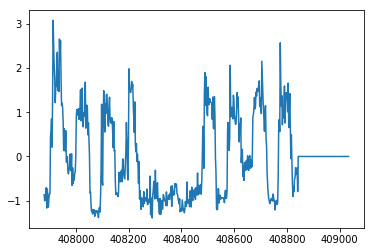

In [39]:
train_dataset.df[train_dataset.df.ForecastId == 359].Value.plot()

In [18]:
a = np.random.randint(1,size=(1,192))

In [ ]:
np.vstack([a] * 16)

In [22]:
list(range(0,16))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [21]:
np.vstack([a] * 16).shape

(16, 192)

In [15]:
x1.shape,x2.shape,y.shape

((64, 192), (64, 384, 8), (64, 192))

In [47]:
x2[idx,0].shape

(8,)

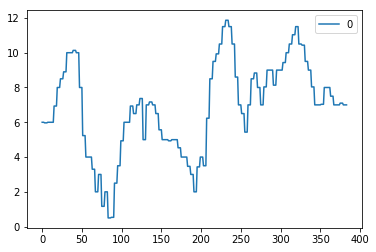

In [48]:
import matplotlib.pyplot as plt
idx = 10
plot_df = pd.DataFrame(list(x2[idx,:,0]))
plot_df.plot()
plt.show()

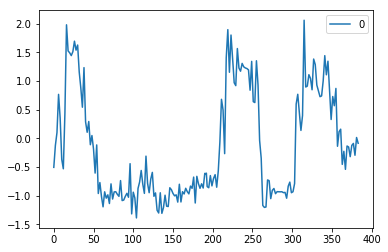

In [35]:
import matplotlib.pyplot as plt
idx = 38
plot_df = pd.DataFrame(list(x1[idx,:])+list(y[idx+10,:]))
plot_df.plot()
plt.show()

In [ ]:
def save_checkpoint(state, is_best, filename, best_filename):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, best_filename)

